### Utah Crash and Road Centerline Analysis
#### Horace Hou
##### This notebook performs the following tasks:
###### 1. Reads in crash data (assumed to be in CSV format with "longitude" and "latitude" columns) and road centerline data (e.g., a shapefile).
###### 2. Converts the crash data into a GeoDataFrame.
###### 3. Finds the intersection of crash points with road centerlines using a spatial join.
###### 4. Uses scikit‑learn’s DBSCAN and OPTICS to cluster the crash data based on location.
###### 5. Visualizes the resulting clusters using Seaborn.

##### Data
###### - UtahCrashData.csv
###### - UtahRoads.shp

In [1]:
! pip install geopandas

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN, OPTICS
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('UtahCrashData.csv')
df.head()

,the_geom,OBJECTID,crash_id,crash_date,crash_year,crash_month,crash_day,crash_hour,crash_minute,construction,...,officer_name,officer_department,road_name,road_type,route_number,milepost,city,county,utm_x,utm_y
0,POINT (-112.195961500523 41.705980541357),65019,10918098,01/05/2017 01:30:00 PM +0000,2017,1,5,13,30,0,...,UHP.UT.USA,UTUHP1900,I-84,Mainline,84.0,41.468000,OUTSIDE CITY LIMITS,BOX ELDER,400497.832462,4.617823e+06
1,POINT (-111.890950655091 40.50907424456),118086,11015745,11/28/2017 07:59:00 AM +0000,2017,11,3,7,59,0,...,UHP.UT.USA,UTUHP1300,I-15,Mainline,15.0,290.090000,DRAPER,SALT LAKE,424516.006446,4.484643e+06
2,POINT (-112.039132037187 41.234800428135),52191,10911038,12/28/2016 03:52:18 PM +0000,2016,12,4,15,52,0,...,WC,UT0290000,2482 W 1775 S,Mainline,578289.0,0.100000,WEST HAVEN,WEBER,412917.639935,4.565343e+06
3,POINT (-111.854798359825 40.626080913744),86114,10964323,05/26/2017 08:14:23 AM +0000,2017,5,6,8,14,0,...,CHPD,UT0184200,7123 S 1300 E,Mainline,2068.0,8.751000,COTTONWOOD HEIGHTS,SALT LAKE,427705.000000,4.497601e+06
4,POINT (-111.891238818464 40.516726594813),120566,11019708,11/30/2017 12:10:00 PM +0000,2017,11,5,12,10,0,...,UHP.UT.USA,UTUHP1300,I-15,Mainline,15.0,290.618208,DRAPER,SALT LAKE,424500.176082,4.485493e+06


In [4]:
# Transform Universal Transverse Mercator (UTM, EPSG:32612) to lat long (WGS84, EPSG:4326)
from pyproj import Transformer

# EPSG:32612 corresponds to UTM Zone 12N in the northern hemisphere.
transformer = Transformer.from_crs("EPSG:32612", "EPSG:4326", always_xy=True)

# Test
utm_x = 400497.83246201999
utm_y = 4617823.3808992701
transformer.transform(utm_x, utm_y)

(-112.19596150065225, 41.705980540576654)

In [5]:
# Convert UTM to latitude and longitude
df['lon'], df['lat'] = transformer.transform(df['utm_x'].values, df['utm_y'].values)
df.head()

,the_geom,OBJECTID,crash_id,crash_date,crash_year,crash_month,crash_day,crash_hour,crash_minute,construction,...,road_name,road_type,route_number,milepost,city,county,utm_x,utm_y,lon,lat
0,POINT (-112.195961500523 41.705980541357),65019,10918098,01/05/2017 01:30:00 PM +0000,2017,1,5,13,30,0,...,I-84,Mainline,84.0,41.468000,OUTSIDE CITY LIMITS,BOX ELDER,400497.832462,4.617823e+06,-112.195962,41.705981
1,POINT (-111.890950655091 40.50907424456),118086,11015745,11/28/2017 07:59:00 AM +0000,2017,11,3,7,59,0,...,I-15,Mainline,15.0,290.090000,DRAPER,SALT LAKE,424516.006446,4.484643e+06,-111.890951,40.509074
2,POINT (-112.039132037187 41.234800428135),52191,10911038,12/28/2016 03:52:18 PM +0000,2016,12,4,15,52,0,...,2482 W 1775 S,Mainline,578289.0,0.100000,WEST HAVEN,WEBER,412917.639935,4.565343e+06,-112.039132,41.234800
3,POINT (-111.854798359825 40.626080913744),86114,10964323,05/26/2017 08:14:23 AM +0000,2017,5,6,8,14,0,...,7123 S 1300 E,Mainline,2068.0,8.751000,COTTONWOOD HEIGHTS,SALT LAKE,427705.000000,4.497601e+06,-111.854798,40.626081
4,POINT (-111.891238818464 40.516726594813),120566,11019708,11/30/2017 12:10:00 PM +0000,2017,11,5,12,10,0,...,I-15,Mainline,15.0,290.618208,DRAPER,SALT LAKE,424500.176082,4.485493e+06,-111.891239,40.516727


In [6]:
# Create point geometry from crash data
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs="EPSG:4326")
gdf.head()

,the_geom,OBJECTID,crash_id,crash_date,crash_year,crash_month,crash_day,crash_hour,crash_minute,construction,...,road_type,route_number,milepost,city,county,utm_x,utm_y,lon,lat,geometry
0,POINT (-112.195961500523 41.705980541357),65019,10918098,01/05/2017 01:30:00 PM +0000,2017,1,5,13,30,0,...,Mainline,84.0,41.468000,OUTSIDE CITY LIMITS,BOX ELDER,400497.832462,4.617823e+06,-112.195962,41.705981,POINT (-112.19596 41.70598)
1,POINT (-111.890950655091 40.50907424456),118086,11015745,11/28/2017 07:59:00 AM +0000,2017,11,3,7,59,0,...,Mainline,15.0,290.090000,DRAPER,SALT LAKE,424516.006446,4.484643e+06,-111.890951,40.509074,POINT (-111.89095 40.50907)
2,POINT (-112.039132037187 41.234800428135),52191,10911038,12/28/2016 03:52:18 PM +0000,2016,12,4,15,52,0,...,Mainline,578289.0,0.100000,WEST HAVEN,WEBER,412917.639935,4.565343e+06,-112.039132,41.234800,POINT (-112.03913 41.2348)
3,POINT (-111.854798359825 40.626080913744),86114,10964323,05/26/2017 08:14:23 AM +0000,2017,5,6,8,14,0,...,Mainline,2068.0,8.751000,COTTONWOOD HEIGHTS,SALT LAKE,427705.000000,4.497601e+06,-111.854798,40.626081,POINT (-111.8548 40.62608)
4,POINT (-111.891238818464 40.516726594813),120566,11019708,11/30/2017 12:10:00 PM +0000,2017,11,5,12,10,0,...,Mainline,15.0,290.618208,DRAPER,SALT LAKE,424500.176082,4.485493e+06,-111.891239,40.516727,POINT (-111.89124 40.51673)


In [7]:
gdf.shape

(256441, 29)

In [8]:
gdf = gdf[gdf['lat'] > 30]
gdf.shape

(237497, 29)

In [9]:
# Read road centerline data
roads = gpd.read_file("Roads.shp")
roads.head()

,STATUS,CARTOCODE,FULLNAME,FROMADDR_L,TOADDR_L,FROMADDR_R,TOADDR_R,PARITY_L,PARITY_R,PREDIR,...,CREATED,CREATOR,EDITOR,CUSTOMTAGS,GlobalID,TDMNET_L,TDMNET_R,PED_L,PED_R,geometry
0,None,11,None,0,0,0,0,None,None,None,...,2015-09-02,TRANSADMIN,UDOT_EDIT,None,925aa835-2c8e-4a7c-9380-0000090e2480,None,None,None,None,"LINESTRING (-12196887.736 4835641.093, -121969..."
1,None,11,EL VALLE DR,521,559,520,558,None,None,E,...,2015-09-02,TRANSADMIN,ENEEMANN,None,f76a3f2e-2f95-458c-b04b-00004ea9daae,None,None,None,None,"LINESTRING (-12525390.016 4446602.571, -125253..."
2,None,11,1185 E,5775,5803,5776,5802,None,None,S,...,2015-09-02,TRANSADMIN,ENEEMANN,None,2872f21a-b1bb-4b06-b33e-0000763b4164,None,None,None,None,"LINESTRING (-12451947.311 4960314.047, -124519..."
3,None,9,TULE VALLEY RD,0,0,0,0,None,None,None,...,2015-09-02,TRANSADMIN,TRANSADMIN,None,273b2f6f-70f4-46fb-bd23-00009a23d43c,None,None,None,None,"LINESTRING (-12620663.074 4712500.276, -126205..."
4,None,11,1ST,227,299,226,298,None,None,N,...,2015-09-02,TRANSADMIN,GBUNCE,None,b55e5cd1-de7e-40bb-8108-00009e004c5d,None,None,None,None,"LINESTRING (-12214539.545 5011213.026, -122145..."


In [10]:
roads = roads.to_crs(gdf.crs)
roads_buffered = roads.copy()
roads_buffered["geometry"] = roads_buffered.geometry.buffer(0.0001)
crash_on_roads = gpd.sjoin(gdf, roads_buffered, how="inner", predicate="intersects")

/tmp/ipykernel_2989/4098990944.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roads_buffered["geometry"] = roads_buffered.geometry.buffer(0.0001)


In [11]:
crash_on_roads.head()

,the_geom,OBJECTID,crash_id,crash_date,crash_year,crash_month,crash_day,crash_hour,crash_minute,construction,...,EXPIRE,CREATED,CREATOR,EDITOR,CUSTOMTAGS,GlobalID,TDMNET_L,TDMNET_R,PED_L,PED_R
0,POINT (-112.195961500523 41.705980541357),65019,10918098,01/05/2017 01:30:00 PM +0000,2017,1,5,13,30,0,...,1899-12-30,2015-09-02,TRANSADMIN,ENEEMANN,None,d2f82d59-fa4e-4f92-9a77-09dd4fb24ec8,None,None,Restricted,Restricted
1,POINT (-111.890950655091 40.50907424456),118086,11015745,11/28/2017 07:59:00 AM +0000,2017,11,3,7,59,0,...,1899-12-30,2015-09-02,TRANSADMIN,ENEEMANN,None,83df03a0-9f52-4d18-bb83-2b1f4704a959,None,None,Restricted,Restricted
1,POINT (-111.890950655091 40.50907424456),118086,11015745,11/28/2017 07:59:00 AM +0000,2017,11,3,7,59,0,...,1899-12-30,2015-09-02,TRANSADMIN,ENEEMANN,None,8c4effb7-3aa2-4215-8fcf-de3a9b825049,None,None,Restricted,Restricted
2,POINT (-112.039132037187 41.234800428135),52191,10911038,12/28/2016 03:52:18 PM +0000,2016,12,4,15,52,0,...,1899-12-30,2015-09-02,TRANSADMIN,ENEEMANN,range overlap with {D1C3E414-AB88-4D8C-AF1F-79...,e9cb37d7-e524-4db8-a4ac-08fd0704752e,None,None,None,None
3,POINT (-111.854798359825 40.626080913744),86114,10964323,05/26/2017 08:14:23 AM +0000,2017,5,6,8,14,0,...,1899-12-30,2015-09-02,TRANSADMIN,EMNEEMANN,None,42f9c0de-8985-4faa-b74a-73405d5636cb,None,None,Sidewalk,Sidewalk


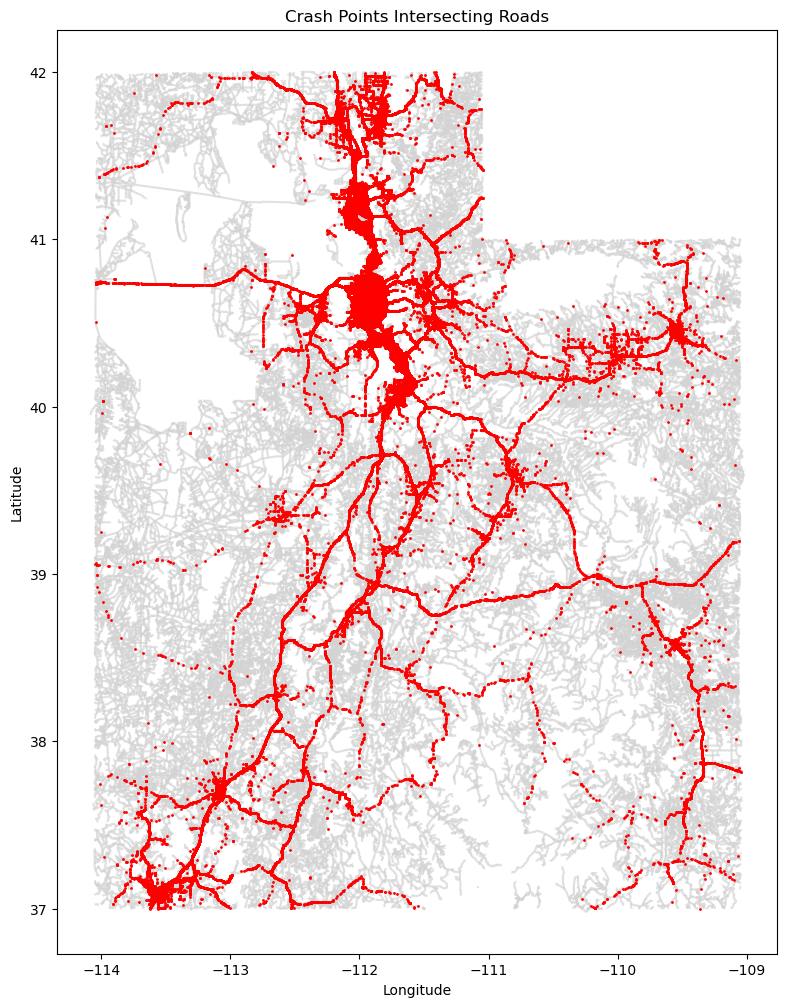

In [12]:
# Plot roads as a base layer
ax = roads.plot(color='lightgray', edgecolor='black', figsize=(12, 12), alpha=0.7, zorder=1)

# Overlay crash points
crash_on_roads.plot(ax=ax, color='red', markersize=1, zorder=2)

# Set the aspect ratio to equal (this ensures that one unit in x is equal to one unit in y)
#ax.set_aspect('equal')

plt.title("Crash Points Intersecting Roads")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [13]:
# Only show data in Salt Lake City
# Define the approximate bounding box for Salt Lake City
min_lat = 40.6
max_lat = 40.9
min_lon = -112.1
max_lon = -111.7

# Filter the GeoDataFrame (crash_on_roads) for points within these bounds
crash_on_roads = crash_on_roads[
    (crash_on_roads['lat'] >= min_lat) &
    (crash_on_roads['lat'] <= max_lat) &
    (crash_on_roads['lon'] >= min_lon) &
    (crash_on_roads['lon'] <= max_lon)
]

In [ ]:
X = crash_on_roads[['lon', 'lat']].values
dbscan = DBSCAN().fit(X)

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', hue='dbscan_cluster', data=crash_on_roads, palette='viridis', s=50)
plt.title("DBSCAN Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

In [ ]:
# Scatter plot of data points, color-coded by cluster assignment
plt.scatter(df['lon'], df['lat'], c=dbscan, s=1, cmap='viridis')

# Labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clusters')
plt.legend()
plt.show()

In [ ]:
op = OPTICS().fit(X)